In [1]:
import pydriver
import numpy as np 
import sklearn, sklearn.cluster, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, precision_recall_curve
import pandas as pd
import copy, datetime 
import itertools
from random import shuffle,random
from collections import Counter

import glob, os

In [2]:
path = "/mnt/storage/home/ja17618/scratch/DATA_DIR/training/"
label_path ='/mnt/storage/home/ja17618/scratch/models/research/deeplab/datasets/labels.csv'
f_lidar = glob.glob(os.path.join(path, 'velodyne', '*.bin'))
f_rgb = glob.glob(os.path.join(path, 'image_2', '*.png'))
f_labels = glob.glob(os.path.join(path, 'label_2', '*.txt'))
data_tag = [name.split('/')[-1].split('.')[-2] for name in f_lidar]
files=[tag+".bin" for tag in data_tag]

In [3]:
# point cloud coloring (False: reflectance, True: camera)
USE_IMAGE_COLOR = False
reader = pydriver.datasets.kitti.KITTIObjectsReader(path)
reconstructor = pydriver.preprocessing.LidarReconstructor(
    useImageColor=USE_IMAGE_COLOR,
    removeInvisible=True,
    )
# mandatory ground truth categories
DETECTION_CATEGORIES = ['car','van', 'truck', 'pedestrian', 'person_sitting', 'cyclist','tram']
# optional ground truth categories
DETECTION_CATEGORIES_OPT = ['misc', 'dontcare']

MIN_OVERLAP = 0.7               # minimal overlap between 2D boxes
EVALUATION_MODE = 'hard'    # mode (easy, moderate, hard)
VISUALIZE3D = False  

In [4]:
SHOT_RADIUS = 2.0
preprocessor = pydriver.preprocessing.Preprocessor(reconstructor)
keypointExtractor = pydriver.keypoints.ISSExtractor(salientRadius=0.25, nonMaxRadius=0.25)
featureExtractor = pydriver.features.SHOTColorExtractor(shotRadius=SHOT_RADIUS, fixedY=-1.0)
featureTypes = [('myfeature', featureExtractor.dims),]


In [5]:
# # function the vocabularies will use to create category storages
# def storageGenerator(dims, category):
#     sto = pydriver.detectors.vocabularies.Storage(dims, category,
#         preprocessors=[],
#         regressor=sklearn.neighbors.KNeighborsRegressor(n_neighbors=1),
#         )
#     return sto
# # function the detector will use to create vocabularies
# def vocabularyGenerator(dimensions, featureName):
# #     ada_clf=sklearn.ensemble.AdaBoostClassifier(n_estimators=75)
# #     svm_clf = sklearn.svm.SVC(probability=True)
# #     rand_clf =sklearn.ensemble.RandomForestClassifier()
# #     voting_clf = sklearn.ensemble.VotingClassifier(estimators=[('ada', ada_clf),('svc',svm_clf),('rf',rand_clf)],voting='soft')
# #     bag_clf = sklearn.ensemble.BaggingClassifier(n_estimators=65,n_jobs=-1,max_samples=10)

#     voc = pydriver.detectors.vocabularies.Vocabulary(
#         dimensions,
#         preprocessors=[
#             sklearn.cluster.MiniBatchKMeans(n_clusters=50, batch_size=10),#, max_iter=100),
#             ],
#         classifier=sklearn.ensemble.AdaBoostClassifier(n_estimators=120),
#         storageGenerator=storageGenerator,
#         balanceNegatives=True,
#         )
#     return voc

In [6]:
# function the vocabularies will use to create category storages
def storageGenerator(dims, category):
    sto = pydriver.detectors.vocabularies.Storage(dims, category,
        preprocessors=[],
        regressor=sklearn.neighbors.KNeighborsRegressor(n_neighbors=1),
        )
    return sto
# function the detector will use to create vocabularies
def vocabularyGenerator(dimensions, featureName):
#     ada_clf=sklearn.ensemble.AdaBoostClassifier(n_estimators=75)
#     svm_clf = sklearn.svm.SVC(probability=True)
#     rand_clf =sklearn.ensemble.RandomForestClassifier()
#     voting_clf = sklearn.ensemble.VotingClassifier(estimators=[('ada', ada_clf),('svc',svm_clf),('rf',rand_clf)],voting='soft')
#     bag_clf = sklearn.ensemble.BaggingClassifier(n_estimators=65,n_jobs=-1,max_samples=10)

    voc = pydriver.detectors.vocabularies.Vocabulary(
        dimensions,
        preprocessors=[
            sklearn.cluster.MiniBatchKMeans(n_clusters=50, batch_size=10),#, max_iter=100),
            ],
        classifier=sklearn.ensemble.AdaBoostClassifier(n_estimators=120),
        storageGenerator=storageGenerator,
        balanceNegatives=True,
        )
    return voc

In [7]:
# initialize detector that will perform learning and recognition
detector = pydriver.detectors.Detector(featureTypes, vocabularyGenerator=vocabularyGenerator)
detector=detector.load('working_model')

In [8]:
context_df = pd.read_csv(label_path,dtype={'frame': np.int32, 'context': np.str},names=['frame','context'],header=0,index_col=False)
# context_df['frame']=context_df['frame'].apply(lambda x: '{0:0>6}'.format(x))

# context_df = pd.read_csv(label_path,index_col=False,header=0)
def get_training_frames(num=1000,shuf=0):
    urban = context_df.loc[context_df['context']=='urban','frame'][:num]
    non_urban = context_df.loc[context_df['context']=='non-urban','frame'][:num]
    ret = [x for x in itertools.chain.from_iterable(itertools.zip_longest(urban,non_urban)) if x]
    if shuf:
        return shuffle(ret)
    else:
        return ret
    
def original_context(frame):
    c_df = context_df[context_df['frame']==frame]
    return str(c_df['context'].values[0]).lower()


In [9]:
# # for image,pcl,label in zip(f_rgb,f_lidar,f_labels):
# #     print("File Number %s" %(image.split('/')[-1].split('.')[-2]))
# #     raw_lidar = np.fromfile(pcl,dtype=np.float32).reshape((-1,4))
# #     scene = preprocessor.process(raw_lidar)
# #     input()
# np.set_printoptions(threshold=np.inf)
# timeStart = datetime.datetime.now()
# cnt=0
# passed=0
# for frame in get_training_frames(50):
    
#     frame = reader.getFrameInfo(frame)
#     print('Training on frame %d...' % frame['frameId'])
#     scene = preprocessor.process(frame)
#     keypointCloud = keypointExtractor.getKeypointCloud(scene)
#     fkeypoints, features = featureExtractor.getFeatures(scene, keypointCloud)
# #     print(fkeypoints)
# #     groundTruth, groåndTruthOpt = pydriver.datasets.kitti.getKITTIGroundTruth(
#         frame['labels'],
#         DETECTION_CATEGORIES,
#         DETECTION_CATEGORIES_OPT,
#         mode='hard',    # use moderate mode for training
#         )
#     category = get_context(frame['frameId'])
#     boxes3D_exclude = []
# #     if len(groundTruth)== 0: 
# #             cnt+=1
# #             print(cnt)
# #             if category == 'urban':

# #                 # get keypoints which lie inside the labeled object box
# # #                 boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
# #                 # extract features at these keypoints (and get new keypoints
# #                 # which depend on the feature extractor)
# #                 try:
# # #                     fkeypoints, features = featureExtractor.getFeatures(scene, keypointCloud)
# #                     # learn new features and relations between features and objects
# #                     detector.addWords(category, 'myfeature', features, fkeypoints)

# #                 except:
# #                     passed+=1
# #                     pass

# #             if category == 'non-urban':
# #             # get keypoints which lie inside the labeled object box
# #     #             box3D_exclude = copy.deepcopy(box3D)
# #     #             box3D_exclude['dimensions']['height'] += 2*SHOT_RADIUS
# #     #             box3D_exclude['dimensions']['width'] += 2*SHOT_RADIUS
# #     #             box3D_exclude['dimensions']['length'] += 2*SHOT_RADIUS
# #     #             boxes3D_exclude.append(box3D_exclude)
# #     #             negativeKeypointCloud = keypointCloud.extractOrientedBoxes(boxes3D_exclude, invert=True)
# #     # # # extract features at these keypoints
# #     #             fkeypoints, features = featureExtractor.getFeatures(scene, negativeKeypointCloud)
# #     # # learn features associated with absence of objects
# #     #             detector.addWords('negative', 'myfeature', features)
# #     # #             boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
# #     #                 # extract features at these keypoints (and get new keypoints
# #     #                 # which depend on the feature extractor)
# #     #             fkeypoints, features = featureExtractor.getFeatures(scene, boxKeypointCloud)
# # #                 boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
# #                 try:
# # #                     fkeypoints, features = featureExtractor.getFeatures(scene, keypointCloud)
# #                     # learn new features and relations between features and objects
# #                     detector.addWords(category, 'myfeature', features, fkeypoints)
# #                 except:
# #                     passed+=1
# #                     pass
# #                     # learn new features and relations between features and objects

        
# #     else:
        
#     for label in groundTruth + groundTruthOpt:
#         box3D = pydriver.geometry.transform3DBox(label['box3D'], scene['transformation'])
#         # avoid training with non-negative examples
#         # the box is made bigger so SHOT features used as negatives
#         # don't capture parts of the object
# #         box3D_exclude = copy.deepcopy(box3D)
# #         box3D_exclude['dimensions']['height'] += 2*SHOT_RADIUS
# #         box3D_exclude['dimensions']['width'] += 2*SHOT_RADIUS
# #         box3D_exclude['dimensions']['length'] += 2*SHOT_RADIUS
# #         boxes3D_exclude.append(box3D_exclude)
# #         if label in groundTruth:
#         if category == 'urban':

#             # get keypoints which lie inside the labeled object box
#             boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
#             # extract features at these keypoints (and get new keypoints
#             # which depend on the feature extractor)
#             fkeypoints, features = featureExtractor.getFeatures(scene, boxKeypointCloud)
#                 # learn new features and relations between features and objects
#             detector.addWords(category, 'myfeature', features, fkeypoints,box3D)

#         if category == 'non-urban':
#         # get keypoints which lie inside the labeled object box
# #             box3D_exclude = copy.deepcopy(box3D)
# #             box3D_exclude['dimensions']['height'] += 2*SHOT_RADIUS
# #             box3D_exclude['dimensions']['width'] += 2*SHOT_RADIUS
# #             box3D_exclude['dimensions']['length'] += 2*SHOT_RADIUS
# #             boxes3D_exclude.append(box3D_exclude)
# #             negativeKeypointCloud = keypointCloud.extractOrientedBoxes(boxes3D_exclude, invert=True)
# # # # extract features at these keypoints
# #             fkeypoints, features = featureExtractor.getFeatures(scene, negativeKeypointCloud)
# # # learn features associated with absence of objects
# #             detector.addWords('negative', 'myfeature', features)
# # #             boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
# #                 # extract features at these keypoints (and get new keypoints
# #                 # which depend on the feature extractor)
# #             fkeypoints, features = featureExtractor.getFeatures(scene, boxKeypointCloud)
#             boxKeypointCloud = keypointCloud.extractOrientedBoxes([box3D])
#             fkeypoints, features = featureExtractor.getFeatures(scene, boxKeypointCloud)
#             detector.addWords('negative', 'myfeature', features,fkeypoints,box3D)
#                 # learn new features and relations between features and objects

# print("passed: %d" %passed)            
# timeTraining = datetime.datetime.now() - timeStart 
# # perform learning on stored data
# print('Learning...')
# timeStart = datetime.datetime.now()
# detector.learn(nStorageMaxRandomSamples=25000)
# timeLearning = datetime.datetime.now() - timeStart


In [11]:
# print(timeTraining)
# print(timeLearning)
def predict_context(detection,thresh=False):
    contexts = [det['category'].decode('UTF-8') for det in detection]
    c = Counter(contexts)
    cls,num = c.most_common(1)[0]
    tot = sum(c.values())
    prob = num/tot
    if cls=='negative':
        cls='non-urban'
    if thresh:
         if prob<0.6:
            cls='urban'
            prob=1-prob
    return cls,prob

def get_unicode_detections(detection):
    def replace_negative(det):
        if det=='negative':
            return 'non-urban'
        else:
            return det
        
    contexts = [replace_negative(det['category'].decode('UTF-8')) for det in detection]
    c = Counter(contexts)
    cls, num = c.most_common()
    return cls,num
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# evaluator = pydriver.evaluation.Evaluator(minOverlap=MIN_OVERLAP, nPoints=100)
# perform testing with frames which were not used for training
firstFrame = 1000
lastFrame = firstFrame+ 10
timeStart = datetime.datetime.now()
y_pred = []
y_true = []
y_prob =[]
y_frame=[] 
class_names=['non-urban','urban']
cnt=0
for frame in get_training_frames(2000):
    
    frame = reader.getFrameInfo(frame)
#     print('Testing on frame %d...' % frame['frameId'])
    # see the training part above
    scene = preprocessor.process(frame)
    keypointCloud = keypointExtractor.getKeypointCloud(scene)


    # extract keypoints and features for the whole scene
    fkeypoints, features = featureExtractor.getFeatures(scene, keypointCloud)
    # perform recognition on extracted features

    detections = detector.recognize({'myfeature': (fkeypoints,features)})
#     print(detections)
    # convert 3D detections (NumPy array) to labels (list of
    # dictionaries) that include 2D box projections used for evaluation
    # and revert the transformation of the scene, so they have the same
    # coordinate system as the original KITTI labels
#     detections_labels = pydriver.datasets.detections2labels(
#         detections,
#         scene['transformation'].I,    # inverse matrix
#         frame['calibration']['projection_left'],
#         scene['img_left'].shape,
#         )
#     dets =get_detections(detections)
#     print(dets)
    pred,prob = predict_context(detections,thresh=True)
    orig = original_context(frame['frameId'])
#     print(cls,orig)
    if pred != orig: 
        y_frame.append([frame['frameId'],pred,orig])
    y_true.append(orig)
    y_pred.append(pred)
    y_prob.append(prob)
    cnt+=1
    
    if cnt%100==0:
        print('Testing on frame %d...' % frame['frameId'])

timeEvaluation = datetime.datetime.now() - timeStart

# show evaluation results
# print("Training time: %s" % timeTraining)
# print("Learning time: %s" % timeLearning)
# print("Evaluation time: %s" % timeEvaluation)



/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/site-packages/ipykernel/__main__.py:86: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
/mnt/storage/home/ja17618/.conda/envs/vox/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Testing on frame 110...
Testing on frame 240...
Testing on frame 374...
Testing on frame 514...
Testing on frame 631...
Testing on frame 791...
Testing on frame 946...
Testing on frame 1087...
Testing on frame 1326...
Testing on frame 1467...
Testing on frame 1632...
Testing on frame 1777...
Testing on frame 1958...
Testing on frame 2105...
Testing on frame 2236...
Testing on frame 2368...
Testing on frame 2501...
Testing on frame 2650...
Testing on frame 2779...
Testing on frame 2898...
Testing on frame 3081...
Testing on frame 3345...
Testing on frame 3589...
Testing on frame 3843...
Testing on frame 4056...
Testing on frame 4328...
Testing on frame 4639...
Testing on frame 4911...
Testing on frame 5177...
Testing on frame 5418...


Confusion matrix, without normalization
[[ 473  548]
 [ 540 1463]]
Normalized confusion matrix
[[0.4632713  0.5367287 ]
 [0.26959561 0.73040439]]


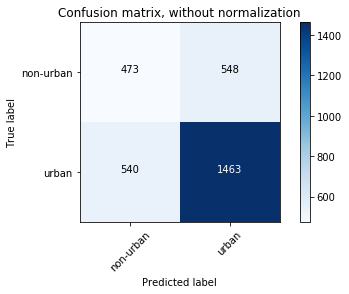

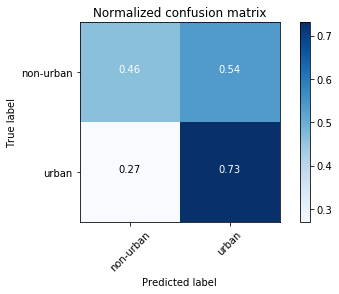

In [14]:
# print([(x,y) for x,y  in zip(y_true,y_prob) if x=='non-urban'])
cnf_matrix = confusion_matrix(y_true,y_pred,labels=class_names)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')




Average precision: 0.57


Text(0.5,1,'2-class Precision-Recall curve: AP=0.57')

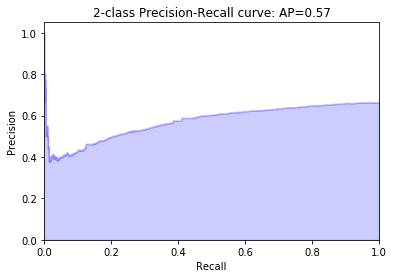

In [13]:
# print(set(y_true))
# print(set(y_pred))
y = [np.where(y_t == 'urban', True, False) for y_t in y_true]

avg_prec = average_precision_score(y,y_prob)
print("Average precision: %.2f" % avg_prec)

precision, recall, _ = precision_recall_curve(y, y_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          avg_prec))

In [ ]:
# detector.save('working_model')

In [15]:
incorrect_df = pd.DataFrame(y_frame,columns=['frame','predicted','original'])
incorrect_df.to_csv("incorrect.csv",index=False)